<a href="https://colab.research.google.com/github/unclesam243/DS6050/blob/main/Lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [1]:
import numpy as np
np.random.seed(42)

from sklearn.datasets import fetch_covtype
covtype = fetch_covtype()
X = covtype.data
y = covtype.target

print("X shape", X.shape)
print("y shape", y.shape)

X shape (581012, 54)
y shape (581012,)


In [2]:
y_binary =(y==2).astype(int)
print("Class 0 (Not Pint)", (y_binary == 0).sum())
print("Class 1 (Pine)", (y_binary == 1).sum())
print(f"Slope: {X[:,2].min():.0f} to {X[:,2].max():.0f}")

Class 0 (Not Pint) 297711
Class 1 (Pine) 283301
Slope: 0 to 66


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42
    )

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#

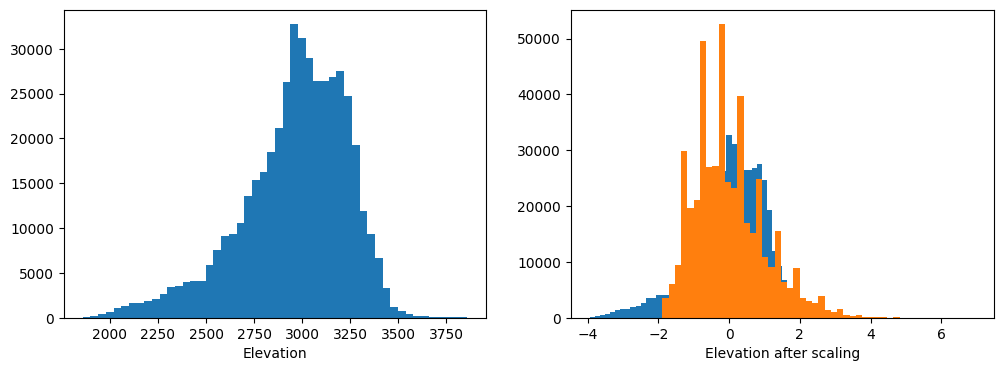

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(X_train[:,0], bins=50)
axes[0].set_xlabel("Elevation")
axes[1].hist(X_train_scaled[:,0], bins=50)
axes[1].set_xlabel("Elevation after scaling")
plt.hist(X_train_scaled[:,2], bins=50)
plt.show()
#

In [7]:
import torch
torch.manual_seed(42)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")


Using Device: cuda


In [22]:
tensor_x_train = torch.tensor(X_train_scaled).float().to(device)
tensor_y_train = torch.tensor(y_train).float().to(device)
tensor_x_test = torch.tensor(X_test_scaled).float().to(device)
tensor_y_test = torch.tensor(y_test).float().to(device)


train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)

class TabularMLP(nn.Module):
  def __init__(self,input_dim):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    self.layer2 = nn.Linear(64,32)
    self.layer3 = nn.Linear(32,1)
  def forward(self,x):
    x = torch.relu(self.layer1(x))
    x = torch.relu(self.layer2(x))
    x = self.layer3(x) # Fixed: Changed self.output(x) to self.layer3(x)
    return x

In [20]:
model = TabularMLP(tensor_x_train.shape[1]).to(device)
print(model)

TabularMLP(
  (layer1): Linear(in_features=54, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {n_params}")

Number of parameters: 5633


In [21]:
criterion= nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 10

loss_history = []

for epoch in range(NUM_EPOCHS):
  epoch_loss = 0.0 # Initialize epoch_loss at the beginning of each epoch
  for batch_x, batch_y in train_loader:
    optimizer.zero_grad()
    predictions = model(batch_x)
    loss = criterion(predictions.squeeze(), batch_y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  avg_loss = epoch_loss / len(train_loader)
  loss_history.append(avg_loss)

  if (epoch+1) % 1 == 0:
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.4066
Epoch [2/10], Loss: 0.3364
Epoch [3/10], Loss: 0.3091
Epoch [4/10], Loss: 0.2906
Epoch [5/10], Loss: 0.2792
Epoch [6/10], Loss: 0.2702
Epoch [7/10], Loss: 0.2632
Epoch [8/10], Loss: 0.2579
Epoch [9/10], Loss: 0.2531
Epoch [10/10], Loss: 0.2492


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(loss_history, marker = 'o')
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score
model.eval()
with torch.no_grad():
  logits = model(tensor_x_test)
  probs = torch.sigmoid(logits)
  preds = (probs > 0.5).int()

preds_np = preds.cpu().numpy()
probs_np = probs.cpu().numpy()
nn_acc = accuracy_score(y_test, preds_np)
nn_auc = roc_auc_score(y_test, probs_np)

print(f"Accuracy: {nn_acc:.4f}")
print(f"AUC: {nn_auc:.4f}")

Accuracy: 0.8928
AUC: 0.9611


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_preds)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:,1])

print(f"Accuracy: {lr_acc:.4f}")
print(f"AUC: {lr_auc:.4f}")

Accuracy: 0.7557
AUC: 0.8262


In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_preds)

In [26]:
print(f"Accuracy: {rf_acc: .4f}")

Accuracy:  0.8521
